# Reminder of DistributionLambda

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers
import numpy as np
import matplotlib.pyplot as plt

In [29]:
model = Sequential([
    Dense(16, activation='relu', input_shape=(2,)),
    Dense(2),  
    # the previous dense layer outputs a tensor with shape (batch_size, 2)
    # and this tensor is then used to parameterize the normal distribution
    tfpl.DistributionLambda(
        lambda t: tfd.Independent(tfd.Normal(loc=t[..., :1],
                                             # by using the softplus function we ensure that the
                                             # tensor is a positive value as it needs to be as it is 
                                             # the standard deviation of the distribution
                                            scale=tf.math.softplus(t[..., 1:]))))
])

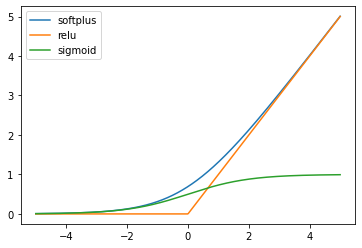

In [26]:
a = np.linspace(-5, 5, 500)
b = tf.keras.activations.softplus(a) 
c = tf.keras.activations.relu(a) 
d = tf.keras.activations.sigmoid(a) 
plt.plot(a, b.numpy(), label='softplus')
plt.plot(a, c.numpy(), label='relu')
plt.plot(a, d.numpy(), label='sigmoid')
plt.legend();

In [38]:
x_sample_mu = tfd.Normal(0, 1).sample(16)
x_sample_std = tfd.HalfNormal(1).sample(16)
x_sample = np.concatenate((x_sample_mu.numpy().reshape(-1,1), x_sample_std.numpy().reshape(-1,1)), axis=1)

In [39]:
x_sample.shape

(16, 2)

In [40]:
model(x_sample)

<tfp.distributions.Independent 'sequential_5_distribution_lambda_5_Independentsequential_5_distribution_lambda_5_Normal' batch_shape=[16] event_shape=[1] dtype=float32>

In [41]:
# Another equivalent way to write our previous model 

model = Sequential([
    Dense(16, activation='relu', input_shape=(2,)),
    Dense(2),
    tfpl.IndependentNormal(1) # This 1 here represents the event shape of the distribution
])

In [42]:
model(x_sample)

<tfp.distributions.Independent 'sequential_6_independent_normal_IndependentNormal_Independentsequential_6_independent_normal_IndependentNormal_Normal' batch_shape=[16] event_shape=[1] dtype=float32>

In [43]:
# Now we have an Independent Normal with an event shape of 2, which represents a 
# two-dimensional multivariate normal with a diagonal covariance matrix
# So the mean now is two-dimensional and we also need two parameters to specify
# the std of the two components

model = Sequential([
    Dense(16, activation='relu', input_shape=(2,)),
    Dense(4),
    tfpl.IndependentNormal(2) 
])

In [46]:
# We can also specify an event shape with a rank that is greater than 1
# which means that in total we have 4 normally distributed random variables
# that are independent from each other.
# That requires 8 parameters, that is why the previous dense layer now has 8 units

model = Sequential([
    Dense(16, activation='relu', input_shape=(2,)),
    Dense(8),
    tfpl.IndependentNormal([2,2]) 
])

In [47]:
model(x_sample)

<tfp.distributions.Independent 'sequential_9_independent_normal_3_IndependentNormal_Independentsequential_9_independent_normal_3_IndependentNormal_Normal' batch_shape=[16] event_shape=[2, 2] dtype=float32>

In [50]:
# When we are parameterizing the previous layer we can make use of the following static method

event_shape=2

model = Sequential([
    Dense(16, activation='relu', input_shape=(2,)),
    Dense(tfpl.IndependentNormal.params_size(event_shape)),
    tfpl.IndependentNormal(event_shape,
    # remember that we can specify functions to model the way the tensor
    # is outputed from this layer
                           convert_to_tensor_fn=tfd.Distribution.sample)
])

In [53]:
# We can use these layers with other models, here we can see an example
# with a standard convolution neural network

from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D

# This is a classifier model for a dataset with 10 classes
num_classes = 10

model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((3, 3)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(tfpl.OneHotCategorical.params_size(num_classes)),
    tfpl.OneHotCategorical(num_classes)
])

In [ ]:
# This model can be trained with the same principle of log likelihood

model.compile(loss=lambda y_true, y_pred: -y_pred.log_prob(y_true))
model.fit(x_train, y_train, epochs=20)

In [ ]:
# At test time

# We can get the probabilities for each class from the categorical distribution
# using the mean method
model(x_test).mean()  # x_test: (1, 32, 32, 3) The first dimension is the batch size

# We also can simply sample from this distribution using the sample method
model(x_test).sample()